# Latest Thesis Work
- 2018-03-03 15:17:14 
- Author: Betty, Yuri

# 分析师荐股质量——基于社会资本视角
## The quality of the stock recommendation of analytist -- based on social capital prospect

---

### 1. Data Preprocessing
- Load data from xls(x) files, transformed as pandas Dataframe object
- Clean and process variable values by columns according to demand (PLZ see details in notebook files)
- Construct the variable matrix  

### 2. Modelling
- Build 3 linear regression models with 4 groups of response variables
- Implement with statsmodels Ordinary Least Squares (OLS)
- Calculate the t-statistics and p-values for analysising  

### 3. Result Analysis
- Analysis based on p-values,t-statistics, descriptive statistics and correlation-coefficient matrix
- Use group verification to test the robustness of the model

## 1. Data Pre-processing

In [161]:
import pandas as pd
import numpy as np
import statsmodels.api as smd
# from statsmodels.regression import linear_model
import requests
import json
import editdistance
import statsmodels.formula as smf
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
%matplotlib inline

In [2]:
%%time
model_data=pd.read_excel('betty_data/模型1-2018.2.2-2046.xlsx',sheet_name='final',header=None)
model_data.columns=model_data.iloc[1]
model_data=model_data.drop([0,1,2])
broker_name_groups=model_data.groupby('Brokern')
all_brokers=list(broker_name_groups.groups.keys())
broker_code_dict=dict(map(lambda x:(x,list(set(broker_name_groups.get_group(x)[['InstitutionID']].values.flatten()))[0]), all_brokers))
model_data['Year']=model_data['Year'].apply(lambda x:str(x))

CPU times: user 42.5 s, sys: 348 ms, total: 42.9 s
Wall time: 43.6 s


---

In [3]:
year_ranking={}
for i in range(2002,2017):
    try:
        ranking_df=pd.read_excel('betty_data/company_ranking.xlsx',sheet_name=str(i))
        ranking_df=ranking_df.dropna()
        if ranking_df.shape[0]>20:
            ranking_df=ranking_df[:20]
        year_ranking[str(i)]=ranking_df[ranking_df.columns[1]].values.flatten()
    except:
        pass
ranking_matrix=pd.DataFrame(year_ranking)

In [4]:
%%time
ranking_series=[]
for k,v in model_data[['Year','Brokern']].iterrows():
    if v['Year'] in ranking_matrix.columns:
        in_specific_rank=np.sum(ranking_matrix[v['Year']].apply(lambda x: x in v['Brokern']))
        ranking_series.append(int(np.sign(in_specific_rank)))
    else:
        ranking_series.append(np.nan)

CPU times: user 26.4 s, sys: 0 ns, total: 26.4 s
Wall time: 26.4 s


In [5]:
model_data['SecSize']=ranking_series
model_data=model_data.drop('Duration',axis=1)
value_dict={0:np.nan,'N':0,'Y':1,np.nan:np.nan}
model_data[['Big4']]=model_data['Big4'].apply(lambda x: value_dict[x])
opacity_dict={0:np.nan,'A':1,'B':2,'C':3,'D':4,np.nan:np.nan}
model_data[['CompanyOpacity']]=model_data['CompanyOpacity'].apply(lambda x:opacity_dict[x])

---

In [6]:
%%time
asset=pd.read_excel('betty_data/asset_liability_1990_2017.xlsx',sheet_name='年末数据')
asset.columns=asset.iloc[0]
asset=asset.drop([0,1])
column_list=list(asset.columns)
column_list[2]="year"
column_list[3]="year_code"
column_list=list(map(lambda x:x.replace("'","").strip(),column_list))
asset.columns=column_list
asset['year']=asset['year'].map(lambda x:str(int(x)))
asset=asset[asset['报表类型']=='A']
asset_groups=asset.groupby('证券代码')
asset_groups_keys=list(asset_groups.groups.keys())
asset['roe']=np.nan

CPU times: user 1min 6s, sys: 252 ms, total: 1min 6s
Wall time: 1min 7s


In [7]:
%%time
test_group=None
for key in asset_groups_keys:
    test_group=asset[asset['证券代码']==key]
    mean_liability=(test_group['所有者权益合计']+test_group['所有者权益合计'].shift(-1))/2
    asset['roe'][asset['证券代码']==key] = test_group['净利润']/(mean_liability)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


CPU times: user 43.8 s, sys: 192 ms, total: 44 s
Wall time: 44.3 s


In [8]:
asset.index=asset['year_code']
roe=asset['roe'].dropna()

---

In [9]:
%%time
profit=pd.read_excel('betty_data/profit_1990_2017.xlsx',sheet_name='每年数据（刨除季度）')
profit.columns=profit.iloc[0]
column_list=list(profit.columns)
column_list[1]="year"
column_list[2]="year_code"
column_list=list(map(lambda x:str(x).replace("'","").strip(),column_list))
profit.columns=column_list
profit=profit.drop([0,1],axis=0)
profit['year']=profit['year'].map(lambda x:str(int(x)))
profit=profit[profit['报表类型']=='A']
profit_groups=profit.groupby('证券代码')
profit_groups_keys=list(profit_groups.groups.keys())
profit['growth']=np.nan

CPU times: user 1min 22s, sys: 376 ms, total: 1min 22s
Wall time: 1min 23s


In [10]:
%%time
# 按照组自动计算growth，并填充到相应的证券
for key in profit_groups_keys:
    test_group=profit[profit['证券代码']==key]
#     去掉营业总收入为0的行
    test_group=test_group[test_group['营业总收入']!=0]
#     相减，求growth
    profit_value=test_group['营业总收入']-test_group['营业总收入'].shift(-1)
    profit['growth'][profit['证券代码']==key] = profit_value/test_group['营业总收入'].shift(-1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 3min 57s, sys: 472 ms, total: 3min 58s
Wall time: 3min 58s


In [11]:
profit.index=profit['year_code']
growth=profit['growth'].dropna()
ready_data=model_data.join(roe,on='年-证券代码').join(growth,on='年-证券代码')

---

In [12]:
brokers_response=requests.post('http://jg.sac.net.cn/pages/publicity/resource!search.action',data={
    'filter_EQS_O#otc_id':'01',
    'filter_EQS_O#sac_id':'',
    'filter_LIKES_aoi_name':'',
    'sqlkey':'publicity',
    'sqlval':'ORG_BY_TYPE_INFO'
})
broker_location_dict=json.loads(brokers_response.text)
broker_location_file=open('betty_data/broker_location.json','w+')
broker_location_file.write(json.dumps(broker_location_dict))



18829

In [13]:
location_response=requests.post('http://jg.sac.net.cn/pages/publicity/resource!search.action',data={
    'sqlkey':'statusDimension',
    'sqlval':'SELECT_AREA_INFO'
})
location_dict=json.loads(location_response.text)
location_dict_file=open('betty_data/location_dict.json','w+')
location_dict_file.write(json.dumps(location_dict).strip())
location_dict=dict(map(lambda x:(x['SAC_ID'],x['SAC_NAME']),location_dict))

In [14]:
broker_location_df=pd.DataFrame(list(map(lambda x:{'Brokern':x['AOI_NAME'],'broker_location':location_dict[x['SAC_ID']]},broker_location_dict)))
broker_location_df.index=broker_location_df['Brokern']
broker_location_df['broker_location']=broker_location_df['broker_location'].apply(lambda x:x.split('（')[0])
IPO_basic=pd.read_excel('betty_data/IPO_Cobasic.xls')
IPO_basic=IPO_basic[2:]
IPO_basic.index=IPO_basic['Stkcd']
province_list=list(map(lambda x:x.split('（')[0],location_dict.values()))
def match_province(place):
    filtered_list=list(filter(lambda y:y in place,province_list))
    filtered_list_length=len(filtered_list)
    if filtered_list_length>1:
        return filtered_list[1]
    elif filtered_list_length==1:
        return filtered_list[0]
    else:
        place
IPO_basic['Province']=IPO_basic['Regplc'].apply(lambda x: match_province(x))
ready_data['SecLoct']=ready_data.join(broker_location_df['broker_location'],on='Brokern').join(IPO_basic['Province'],on='Stkcd').apply(lambda x: int(x['broker_location']==x['Province']),axis=1)

---

In [15]:
IPO=pd.read_excel('betty_data/AF_Co.xls')
IPO.index=IPO['Stkcd']
IPO=IPO[2:]
IPO=IPO.dropna(subset=['Udwnm','Sponsor'])
IPO['edit_distance']=IPO.apply(lambda x: min(map(lambda y: editdistance.eval(str(x['Udwnm']),y),str(x['Sponsor']).split(','))),axis=1)
IPO['underwriter']=IPO.apply(lambda x: 1 if x['edit_distance'] < 2 else 0,axis=1)
ready_data=ready_data.join(IPO['underwriter'],on='Stkcd')

---

In [16]:
ready_data=ready_data.join(IPO['Indnme'],on='Stkcd')
removed_industry=['货币金融服务','其他金融业','资本市场服务','保险业','租赁业']
ready_data=ready_data[ready_data.apply(lambda x: x.Indnme not in removed_industry,axis=1)]
ready_data.index=ready_data['ReportID']

---

In [17]:
st_stocks=pd.read_csv('betty_data/st_stock_new1.csv')
st_stocks['Stkcd']=st_stocks['Stkcd'].apply(lambda x: x.split('.')[0])
st_stocks.index=st_stocks['Stkcd']
def test_st(code,year):
    is_st=st_stocks[st_stocks['Stkcd']==code][year]
    if not is_st.empty:
        return is_st.values[0]
    else:
        return np.nan

In [18]:
%%time
ready_data['is_st']=ready_data.apply(lambda x: test_st(x['Stkcd'],x['Year']),axis=1)
ready_data=ready_data[ready_data['is_st']==0]

CPU times: user 1min 7s, sys: 364 ms, total: 1min 8s
Wall time: 1min 8s


---

In [19]:
brokerage=pd.read_excel('betty_data/AF_BrokerageProfile.xls')
brokerage.index=brokerage.InstitutionID
FundShareHolderDict={'N':0,'Y':1,np.nan:np.nan}
brokerage['FundShareholder']=brokerage.FundShareholder.apply(lambda x:FundShareHolderDict[x])
brokerage['InstitutionID']=brokerage['InstitutionID'].apply(lambda x:str(x))
brokerage['Colisted']=brokerage['Colisted'].apply(lambda x:FundShareHolderDict[x])
proportion=brokerage.FundShareholder.dropna()[brokerage.FundShareholder.dropna()==1].count()/brokerage.FundShareholder.dropna().count()
samples=np.zeros(brokerage[brokerage.FundShareholder.isna()].shape[0])
positive_index=np.random.choice(range(samples.shape[0]),size=int(samples.shape[0]*proportion),replace=False)
samples[positive_index]=1
brokerage.FundShareholder[brokerage.FundShareholder.isna()]=samples
brokerage['IYID']=brokerage.apply(lambda x:'%s_%s'%(x['InstitutionID'],x['Accper'].split('-')[0]),axis=1)
brokerage.index=brokerage.IYID
ready_data['IYID']=ready_data.apply(lambda x:'%s_%s'%(x['InstitutionID'],x['Year'].split('-')[0]),axis=1)
ready_data=ready_data.join(brokerage[['FundShareholder','Colisted']],on='IYID')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


---

In [20]:
%%time
optbias_df=pd.DataFrame()
for i in range(1,4):
    data=pd.read_excel('betty_data/AF_Bench%d.xlsx'%(i))
    data=data[2:]
    data.index=data['ReportID']
    optbias_df=pd.concat([optbias_df,data])

CPU times: user 2min 57s, sys: 2.66 s, total: 2min 59s
Wall time: 3min


In [21]:
optbias_df=optbias_df.drop_duplicates()
optbias_df['ForecastOptimism']=optbias_df['ForecastOptimism'].astype(np.float64)
optbias_df=optbias_df.dropna(subset=['ForecastOptimism'])
optbias_grouped=optbias_df.groupby(optbias_df.index)['ForecastOptimism']
optibias=optbias_grouped.mean()

In [22]:
ready_data=ready_data.join(optibias,on='ReportID')

---

In [23]:
%%time
anadf=pd.DataFrame()
for i in range(5):
    data=pd.read_excel('betty_data/AF_AnaforeFeature%d.xls'%(i))
    data=data[2:]
    data.index=data['ReportID']
    anadf=pd.concat([anadf,data])

CPU times: user 16.3 s, sys: 60 ms, total: 16.4 s
Wall time: 18.2 s


In [24]:
anadf=anadf.drop_duplicates()
ready_anadf=anadf[['AnanmID','RelativeOptimism','RelativeRecommendation','RelativeAnaExperience', 'RelativeCoNumber','RelativeNumber']]

In [25]:
ready_data=ready_data.join(ready_anadf,on='ReportID')

---

In [26]:
anaprofile=pd.read_excel('betty_data/AF_AnalystProfile.xls')
anaprofile=anaprofile[2:]
anaprofile['yaID']=anaprofile.apply(lambda x:'%s_%s'%(x['Accper'].split('-')[0],x['AnanmID']),axis=1)
anaprofile.index=anaprofile['yaID']
ready_anaprofile=anaprofile[['AnalystExperience', 'FollowCoNumber','ForecastNumber']]

In [27]:
ready_data['yaID']=ready_data.apply(lambda x:'%s_%s'%(x['Year'],str(x['AnanmID'])),axis=1)
ready_data=ready_data.join(ready_anaprofile,on='yaID')

---

In [28]:
anaranks=pd.read_excel('betty_data/AF_Anarank.xls')
starAnalyst=set(anaranks.AnanmID)

In [29]:
ready_data['IsStarAnalyst']=ready_data['AnanmID'].apply(lambda x:int(x in starAnalyst))

---

In [30]:
financial_report=pd.read_excel('betty_data/financialReport.xlsx',sheet_name='最后结果')
financial_report.index=financial_report['year-code']
financial_report['date']=financial_report['year-code'].apply(lambda x:pd.to_datetime(''.join(x.split('-')[:-1])))
financial_report['code']=financial_report['year-code'].apply(lambda x:x.split('-')[-1])
financial_report['stk_qua']=financial_report.apply(lambda x:'%s_%s_%s'%(x['code'],x['date'].year,x['date'].quarter),axis=1)
financial_report.index=financial_report['stk_qua']
ready_data['stk_qua']=ready_data.apply(lambda x:'%s_%s_%s'%(x['Stkcd'],pd.to_datetime(x['Rptdt']).year,pd.to_datetime(x['Rptdt']).quarter),axis=1)
ready_data=ready_data.join(financial_report['TotalFinancialProportion'],on='stk_qua')

---

In [31]:
final_ready_data=ready_data.drop(['AnanmID','ReportID', '年-券商', '年-证券代码', 'Rptdt', 'Year', 'Stkcd', 'InstitutionID','Growth','ROE','Brokern','is_st', 'Indnme','IYID','yaID','stk_qua'],axis=1)
# final_ready_data=final_ready_data.dropna()
final_ready_data=final_ready_data.apply(lambda x:np.array(x,dtype=np.float64))
# final_ready_data[['CompanySize']]=np.log(np.array(list(map(lambda x:float(x),final_ready_data[['CompanySize']].values.flatten()))))

## 2. Model-1

In [298]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('betty_data/model_result.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.

# Close the Pandas Excel writer and output the Excel file.


In [299]:
model1_result=[]

In [300]:
def annotate_star(pvalue):
    if pvalue>0.1:
        return '{:,.3f}'.format((pvalue))
    if 0.05< pvalue<=0.1:
        return '{:,.3f}'.format((pvalue))+'*'
    if 0.01< pvalue<=0.05:
        return '{:,.3f}'.format((pvalue))+'**'
    if pvalue <=0.01:
        return '{:,.3f}'.format((pvalue))+'***'

In [301]:
def param_annotate_star(pvalue,param):
    if pvalue>0.1:
        return '{:.5f}'.format((param))
    if 0.05< pvalue<=0.1:
        return '{:.5f}'.format((param))+'*'
    if 0.01< pvalue<=0.05:
        return '{:.5f}'.format((param))+'**'
    if pvalue <=0.01:
        return '{:.5f}'.format((param))+'***'

In [302]:
def build_model_result(model):
    tmp_result=pd.DataFrame([model.pvalues,model.params]).T
    tmp_result['p-values']=tmp_result[0]
    tmp_result['params']=tmp_result[1]
    tmp_result=tmp_result.drop([0,1],axis=1)
    return tmp_result.apply(lambda x:param_annotate_star(x['p-values'],x['params']),axis=1)

In [303]:
def build_R_style_expression(Y,X,categoricalX):
    expression=Y+'~'+X[0]
    for x in X[1:]:
        expression=expression+'+'+x
    for cx in categoricalX:
        expression=expression+'+C('+cx+')'
    return expression

In [304]:
def winsoriz(df,columns):
# numerical_columns=['RelativeAccuracy','ActiveAnalyst', 'StarAnalyst','ReportNumber', 'CompanySize',  'AnaAttention','ReportAttention', 'CompanyOpacity', 'EPS', 'roe', 'growth']
    for nv in columns:
        if nv in df.columns:
            lower=df[nv].quantile(q=0.01)
            upper=df[nv].quantile(q=0.99)
            df[nv][df[nv]<lower]=lower
            df[nv][df[nv]>upper]=upper
    return df

### 2.1 y=ForcastOptimism

In [305]:
data=final_ready_data[['ForecastOptimism','RelativeAnaExperience','RelativeCoNumber','RelativeNumber'
                       ,'IsStarAnalyst', 'AnalystExperience','FollowCoNumber','ForecastNumber','roe','LOSS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['ForecastOptimism','RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'])

In [306]:
expression=build_R_style_expression('ForecastOptimism',['RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'],['LOSS','IsStarAnalyst'])
model=smf.api.ols(expression,data=data).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ForecastOptimism   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     207.9
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:24:56   Log-Likelihood:                 81220.
No. Observations:               38679   AIC:                        -1.624e+05
Df Residuals:                   38669   BIC:                        -1.623e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0220      0.000     44.030      0.000       0.021       0.023
C(LOSS)[T.1.0]              0.0039      0.000     11.665      0.000       0.003       0.005
C(IsStarAnalyst)[T.1.0]     0.0003      0.000      0.608      0.543      -0.001       0.001
RelativeAnaExperience      -0.0001   5.13e-05     -2.673      0.008      -0.000   -3.66e-05
RelativeCoNumber        -9.174e-05   1.49e-05     -6.169      0.000      -0.000   -6.26e-05
RelativeNumber           5.794e-06   4.12e-06      1.405      0.160   -2.29e-06    1.39e-05
AnalystExperience           0.0002   4.12e-05      4.216      0.000     9.3e-05       0.000
FollowCoNumber              0.0001   1.93e-05      5.243      0.000    6.35e-05       0.000
ForecastNumber           7.341e-07   7.41e-06      0.099      0.921   -1.38e-05    1.53e-05
roe                        -0.0487      0.001    -40.302      0.000      -0.051      -0.046
==============================================================================
Omnibus:                     6834.941   Durbin-Watson:                   0.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14964.524
Skew:                           1.034   Prob(JB):                         0.00
Kurtosis:                       5.238   Cond. No.                         765.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [307]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model1_result.append(model_result)

### 2.2 y=RelativeOptimism

In [308]:
data=final_ready_data[['RelativeOptimism','RelativeAnaExperience','RelativeCoNumber','RelativeNumber'
                       ,'IsStarAnalyst', 'AnalystExperience','FollowCoNumber','ForecastNumber','roe','LOSS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['RelativeOptimism','RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'])

In [309]:
expression=build_R_style_expression('RelativeOptimism',['RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'],['LOSS','IsStarAnalyst'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeOptimism   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.818
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.86e-06
Time:                        14:24:58   Log-Likelihood:                -60049.
No. Observations:               39400   AIC:                         1.201e+05
Df Residuals:                   39390   BIC:                         1.202e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0971      0.019      5.180      0.000       0.060       0.134
C(LOSS)[T.1.0]              0.0157      0.012      1.260      0.208      -0.009       0.040
C(IsStarAnalyst)[T.1.0]     0.0238      0.016      1.518      0.129      -0.007       0.055
RelativeAnaExperience      -0.0051      0.002     -2.718      0.007      -0.009      -0.001
RelativeCoNumber            0.0012      0.001      2.223      0.026       0.000       0.002
RelativeNumber           3.506e-05      0.000      0.233      0.816      -0.000       0.000
AnalystExperience           0.0015      0.002      0.962      0.336      -0.002       0.004
FollowCoNumber             -0.0030      0.001     -4.162      0.000      -0.004      -0.002
ForecastNumber              0.0008      0.000      2.903      0.004       0.000       0.001
roe                        -0.1581      0.045     -3.476      0.001      -0.247      -0.069
==============================================================================
Omnibus:                    14723.662   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121892.420
Skew:                           1.574   Prob(JB):                         0.00
Kurtosis:                      11.021   Cond. No.                         787.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [310]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model1_result.append(model_result)

### 2.3 y=RelativeRecommendation

In [311]:
data=final_ready_data[['RelativeRecommendation','RelativeAnaExperience','RelativeCoNumber','RelativeNumber'
                       ,'IsStarAnalyst', 'AnalystExperience','FollowCoNumber','ForecastNumber','roe','LOSS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['RelativeRecommendation','RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'])

In [312]:
expression=build_R_style_expression('RelativeRecommendation',['RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'],['LOSS','IsStarAnalyst'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     RelativeRecommendation   R-squared:                       0.005
Model:                                OLS   Adj. R-squared:                  0.004
Method:                     Least Squares   F-statistic:                     21.40
Date:                    Thu, 22 Mar 2018   Prob (F-statistic):           1.43e-36
Time:                            14:25:01   Log-Likelihood:                -34666.
No. Observations:                   42301   AIC:                         6.935e+04
Df Residuals:                       42291   BIC:                         6.944e+04
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0211      0.009      2.394      0.017       0.004       0.038
C(LOSS)[T.1.0]              0.0406      0.006      6.954      0.000       0.029       0.052
C(IsStarAnalyst)[T.1.0]     0.0198      0.007      2.667      0.008       0.005       0.034
RelativeAnaExperience       0.0016      0.001      1.760      0.078      -0.000       0.003
RelativeCoNumber           -0.0013      0.000     -4.910      0.000      -0.002      -0.001
RelativeNumber              0.0004    7.3e-05      5.437      0.000       0.000       0.001
AnalystExperience          -0.0031      0.001     -4.236      0.000      -0.005      -0.002
FollowCoNumber             -0.0012      0.000     -3.609      0.000      -0.002      -0.001
ForecastNumber              0.0002      0.000      1.860      0.063    -1.3e-05       0.000
roe                         0.0212      0.021      0.992      0.321      -0.021       0.063
==============================================================================
Omnibus:                        3.298   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.322
Skew:                          -0.012   Prob(JB):                        0.190
Kurtosis:                       3.036   Cond. No.                         749.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [313]:
# expression=build_R_style_expression('C(RelativeRecommendation)',['RelativeAnaExperience', 'RelativeCoNumber',
#        'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
#        'ForecastNumber', 'roe'],['LOSS','IsStarAnalyst'])
# model=smf.api.mnlogit(expression,data=data).fit()
# model.summary()

In [314]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model1_result.append(model_result)

In [315]:
# expression=build_R_style_expression('C(RelativeRecommendation)',['RelativeAnaExperience', 'RelativeCoNumber',
#        'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
#        'ForecastNumber', 'roe'],['LOSS','IsStarAnalyst'])
# smf.api.mnlogit(expression,data=data).fit()

### 2.4 y=RelativeAccuracy

In [316]:
data=final_ready_data[['RelativeAccuracy','RelativeAnaExperience','RelativeCoNumber','RelativeNumber'
                       ,'IsStarAnalyst', 'AnalystExperience','FollowCoNumber','ForecastNumber','roe','LOSS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['RelativeRemommendation','RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'])

In [317]:
expression=build_R_style_expression('RelativeAccuracy',['RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'],['LOSS','IsStarAnalyst'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeAccuracy   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.993
Date:                Thu, 22 Mar 2018   Prob (F-statistic):            0.00144
Time:                        14:25:04   Log-Likelihood:            -1.0753e+05
No. Observations:               39466   AIC:                         2.151e+05
Df Residuals:                   39456   BIC:                         2.152e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.3770      0.062     -6.059      0.000      -0.499      -0.255
C(LOSS)[T.1.0]             -0.0639      0.041     -1.547      0.122      -0.145       0.017
C(IsStarAnalyst)[T.1.0]     0.0774      0.052      1.485      0.137      -0.025       0.180
RelativeAnaExperience       0.0052      0.006      0.822      0.411      -0.007       0.017
RelativeCoNumber           -0.0021      0.002     -1.146      0.252      -0.006       0.001
RelativeNumber              0.0003      0.000      0.587      0.558      -0.001       0.001
AnalystExperience           0.0008      0.005      0.150      0.881      -0.009       0.011
FollowCoNumber              0.0003      0.002      0.142      0.887      -0.004       0.005
ForecastNumber              0.0008      0.001      0.914      0.361      -0.001       0.003
roe                         0.5249      0.151      3.477      0.001       0.229       0.821
==============================================================================
Omnibus:                   112041.229   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       7662314813.437
Skew:                         -37.784   Prob(JB):                         0.00
Kurtosis:                    2160.286   Cond. No.                         787.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [318]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model1_result.append(model_result)

In [319]:
model1_df=pd.DataFrame()
for df in model1_result:
    model1_df=pd.concat((model1_df,df),axis=1)
model1_df.to_excel(writer,sheet_name='model1_pv')

### 2.5 descriptive statistics

In [320]:
model1_ds_df=final_ready_data[['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy','RelativeAnaExperience','RelativeCoNumber','RelativeNumber'
                       ,'IsStarAnalyst', 'AnalystExperience','FollowCoNumber','ForecastNumber','roe','LOSS']].dropna().describe().applymap(lambda x:'{:.3f}'.format(x)).T
model1_ds_df.to_excel(writer,sheet_name='model1_ds')
model1_ds_df

,count,mean,std,min,25%,50%,75%,max
ForecastOptimism,37304.000,0.021,0.034,-0.210,0.003,0.015,0.034,0.977
RelativeOptimism,37304.000,0.137,3.422,-240.000,-0.360,0.000,0.360,168.280
RelativeRecommendation,37304.000,0.005,0.575,-4.000,0.000,0.000,0.000,2.000
RelativeAccuracy,37304.000,-0.258,3.299,-238.000,-0.260,0.050,0.390,1.000
RelativeAnaExperience,37304.000,0.058,7.226,-23.010,-4.740,-1.160,3.200,39.400
RelativeCoNumber,37304.000,-0.744,29.488,-195.000,-12.000,-3.330,5.440,364.080
RelativeNumber,37304.000,0.406,103.444,-667.500,-43.500,-11.165,21.000,1336.960
IsStarAnalyst,37304.000,0.180,0.384,0.000,0.000,0.000,0.000,1.000
AnalystExperience,37304.000,9.868,8.211,0.000,3.960,7.170,13.460,54.020
FollowCoNumber,37304.000,20.244,21.710,1.000,9.000,15.000,24.000,225.000


In [321]:
data=final_ready_data[['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy','RelativeAnaExperience','RelativeCoNumber','RelativeNumber'
                       ,'IsStarAnalyst', 'AnalystExperience','FollowCoNumber','ForecastNumber','roe','LOSS']].dropna()
def corr_pvalue(df):
    numeric_df = df.dropna()._get_numeric_data()
    cols = numeric_df.columns
    mat = numeric_df.values

    arr = np.zeros((len(cols),len(cols)), dtype=object)

    for xi, x in enumerate(mat.T):
        for yi, y in enumerate(mat.T[xi:]):
            arr[xi, yi+xi] = map(lambda _: round(_,4), pearsonr(x,y))
            arr[yi+xi, xi] = arr[xi, yi+xi]

    return pd.DataFrame(arr, index=cols, columns=cols)
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
rho=data.corr()
pval = calculate_pvalues(data) 
r1 = rho.applymap(lambda x: '{:.3f}*'.format(x))
r2 = rho.applymap(lambda x: '{:.3f}**'.format(x))
r3 = rho.applymap(lambda x: '{:.3f}***'.format(x))
rall=rho.applymap(lambda x: '{:.3f}'.format(x))
rho = rho.mask(pval>0.1,rall)
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)
rho.to_excel(writer,sheet_name='model1_corr')
rho

,ForecastOptimism,RelativeOptimism,RelativeRecommendation,RelativeAccuracy,RelativeAnaExperience,RelativeCoNumber,RelativeNumber,IsStarAnalyst,AnalystExperience,FollowCoNumber,ForecastNumber,roe,LOSS
ForecastOptimism,1.000***,0.138***,0.063***,-0.078***,-0.011**,0.005,0.011**,0.015***,0.006,0.054***,0.068***,-0.077***,-0.024***
RelativeOptimism,0.138***,1.000***,0.044***,-0.191***,-0.004,-0.001,0.001,0.005,-0.001,-0.006,-0.002,-0.009*,-0.007
RelativeRecommendation,0.063***,0.044***,1.000***,-0.016***,-0.010*,-0.034***,-0.014***,0.008,-0.018***,-0.031***,-0.022***,0.008,0.031***
RelativeAccuracy,-0.078***,-0.191***,-0.016***,1.000***,0.013**,0.010*,0.014***,0.013**,0.012**,0.010*,0.013**,0.006,-0.001
RelativeAnaExperience,-0.011**,-0.004,-0.010*,0.013**,1.000***,0.417***,0.497***,0.251***,0.883***,0.124***,0.104***,0.007,0.004
RelativeCoNumber,0.005,-0.001,-0.034***,0.010*,0.417***,1.000***,0.886***,0.184***,0.365***,0.638***,0.576***,-0.003,-0.017***
RelativeNumber,0.011**,0.001,-0.014***,0.014***,0.497***,0.886***,1.000***,0.248***,0.443***,0.535***,0.562***,-0.002,-0.019***
IsStarAnalyst,0.015***,0.005,0.008,0.013**,0.251***,0.184***,0.248***,1.000***,0.279***,0.199***,0.256***,-0.009*,0.025***
AnalystExperience,0.006,-0.001,-0.018***,0.012**,0.883***,0.365***,0.443***,0.279***,1.000***,0.183***,0.160***,-0.008,-0.027***
FollowCoNumber,0.054***,-0.006,-0.031***,0.010*,0.124***,0.638***,0.535***,0.199***,0.183***,1.000***,0.897***,-0.026***,-0.039***


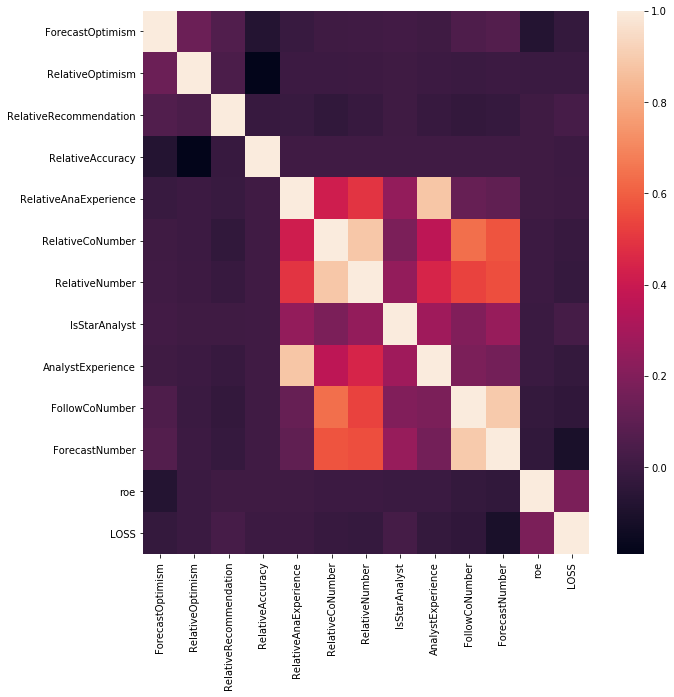

In [322]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(data.corr(),ax=ax)

---
## 3. Model 2

### 3.1 y=ForcastOptimism

In [323]:
model2_result=[]

In [324]:
data=final_ready_data[['ForecastOptimism','CompanyOpacity','ReportAttention','AnaAttention'
                       ,'TotalFinancialProportion', 'SecLoct','LOSS','Big4','growth','CompanySize','roe','EPS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['ForecastOptimism','ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe',
       'EPS','CompanySize'])

In [325]:
expression=build_R_style_expression('ForecastOptimism',['ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe','EPS','CompanyOpacity','np.log(CompanySize)'],['LOSS','Big4','SecLoct'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ForecastOptimism   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     317.8
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:25:11   Log-Likelihood:                 66950.
No. Observations:               31506   AIC:                        -1.339e+05
Df Residuals:                   31494   BIC:                        -1.338e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.1209      0.004    -32.278      0.000      -0.128      -0.114
C(LOSS)[T.1.0]               0.0027      0.000      5.868      0.000       0.002       0.004
C(Big4)[T.1.0]              -0.0062      0.000    -12.470      0.000      -0.007      -0.005
C(SecLoct)[T.1.0]           -0.0029      0.001     -4.785      0.000      -0.004      -0.002
ReportAttention             -0.0001   1.11e-05    -10.963      0.000      -0.000      -0.000
AnaAttention              9.005e-05   3.27e-05      2.755      0.006     2.6e-05       0.000
TotalFinancialProportion    -0.0003   3.39e-05     -8.259      0.000      -0.000      -0.000
growth                      -0.0054      0.000    -12.289      0.000      -0.006      -0.004
roe                         -0.0286      0.002    -16.734      0.000      -0.032      -0.025
EPS                          0.0036      0.000      7.216      0.000       0.003       0.005
CompanyOpacity               0.0047      0.000     16.252      0.000       0.004       0.005
np.log(CompanySize)          0.0062      0.000     39.589      0.000       0.006       0.007
==============================================================================
Omnibus:                     4505.246   Durbin-Watson:                   0.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10009.105
Skew:                           0.851   Prob(JB):                         0.00
Kurtosis:                       5.175   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [326]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model2_result.append(model_result)

### 3.2 y=RelativeOptimism

In [327]:
data=final_ready_data[['RelativeOptimism','CompanyOpacity','ReportAttention','AnaAttention'
                       ,'TotalFinancialProportion', 'SecLoct','LOSS','Big4','growth','CompanySize','roe','EPS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['RelativeOptimism','ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe',
       'EPS','CompanySize'])

In [328]:
expression=build_R_style_expression('RelativeOptimism',['ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe','EPS','CompanyOpacity','np.log(CompanySize)'],['LOSS','Big4','SecLoct'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeOptimism   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.264
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           2.31e-08
Time:                        14:25:13   Log-Likelihood:                -43616.
No. Observations:               29368   AIC:                         8.726e+04
Df Residuals:                   29356   BIC:                         8.736e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2204      0.142      1.547      0.122      -0.059       0.499
C(LOSS)[T.1.0]              -0.0276      0.018     -1.566      0.117      -0.062       0.007
C(Big4)[T.1.0]              -0.0263      0.018     -1.430      0.153      -0.062       0.010
C(SecLoct)[T.1.0]            0.0660      0.024      2.774      0.006       0.019       0.113
ReportAttention              0.0009      0.000      2.144      0.032    7.58e-05       0.002
AnaAttention                -0.0054      0.001     -4.383      0.000      -0.008      -0.003
TotalFinancialProportion    -0.0021      0.001     -1.574      0.115      -0.005       0.001
growth                       0.0200      0.015      1.367      0.172      -0.009       0.049
roe                          0.0429      0.067      0.643      0.520      -0.088       0.174
EPS                          0.0231      0.018      1.265      0.206      -0.013       0.059
CompanyOpacity              -0.0060      0.011     -0.545      0.586      -0.028       0.016
np.log(CompanySize)         -0.0031      0.006     -0.517      0.605      -0.015       0.009
==============================================================================
Omnibus:                     8634.616   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59943.221
Skew:                           1.235   Prob(JB):                         0.00
Kurtosis:                       9.549   Cond. No.                     1.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [329]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model2_result.append(model_result)

### 3.4 y=RelativeRecommendation

In [330]:
data=final_ready_data[['RelativeRecommendation','CompanyOpacity','ReportAttention','AnaAttention'
                       ,'TotalFinancialProportion', 'SecLoct','LOSS','Big4','growth','CompanySize','roe','EPS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['RelativeRecommendation','ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe',
       'EPS','CompanySize'])

In [331]:
expression=build_R_style_expression('RelativeRecommendation',['ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe','EPS','CompanyOpacity','np.log(CompanySize)'],['LOSS','Big4','SecLoct'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     RelativeRecommendation   R-squared:                       0.014
Model:                                OLS   Adj. R-squared:                  0.014
Method:                     Least Squares   F-statistic:                     41.33
Date:                    Thu, 22 Mar 2018   Prob (F-statistic):           7.20e-90
Time:                            14:25:15   Log-Likelihood:                -25321.
No. Observations:                   31333   AIC:                         5.067e+04
Df Residuals:                       31321   BIC:                         5.077e+04
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2611      0.071      3.694      0.000       0.123       0.400
C(LOSS)[T.1.0]               0.0162      0.009      1.866      0.062      -0.001       0.033
C(Big4)[T.1.0]               0.0312      0.009      3.464      0.001       0.014       0.049
C(SecLoct)[T.1.0]            0.0172      0.012      1.483      0.138      -0.006       0.040
ReportAttention             -0.0026      0.000    -12.865      0.000      -0.003      -0.002
AnaAttention                 0.0051      0.001      8.285      0.000       0.004       0.006
TotalFinancialProportion     0.0021      0.001      3.273      0.001       0.001       0.003
growth                      -0.0246      0.007     -3.483      0.000      -0.038      -0.011
roe                          0.0437      0.032      1.365      0.172      -0.019       0.107
EPS                          0.0024      0.009      0.266      0.790      -0.015       0.020
CompanyOpacity               0.0032      0.005      0.593      0.553      -0.007       0.014
np.log(CompanySize)         -0.0114      0.003     -3.889      0.000      -0.017      -0.006
==============================================================================
Omnibus:                        2.929   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                2.980
Skew:                          -0.007   Prob(JB):                        0.225
Kurtosis:                       3.046   Cond. No.                     1.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [332]:
# expression=build_R_style_expression('C(RelativeRecommendation)',['ReportAttention', 'AnaAttention',
#        'TotalFinancialProportion', 'growth', 'roe','EPS','CompanyOpacity','np.log(CompanySize)'],['LOSS','Big4','SecLoct'])
# model=smf.api.mnlogit(expression,data=data).fit()
# model.summary()

In [333]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model2_result.append(model_result)

### 3.4 y=RelativeAccuracy

In [334]:
data=final_ready_data[['RelativeAccuracy','CompanyOpacity','ReportAttention','AnaAttention'
                       ,'TotalFinancialProportion', 'SecLoct','LOSS','Big4','growth','CompanySize','roe','EPS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['RelativeAccuracy','ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe',
       'EPS','CompanySize'])

In [335]:
expression=build_R_style_expression('RelativeAccuracy',['ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe','EPS','CompanyOpacity','np.log(CompanySize)'],['LOSS','Big4','SecLoct'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeAccuracy   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     19.54
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           8.34e-40
Time:                        14:25:18   Log-Likelihood:                -41173.
No. Observations:               29415   AIC:                         8.237e+04
Df Residuals:                   29403   BIC:                         8.247e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.2796      0.131     -2.140      0.032      -0.536      -0.024
C(LOSS)[T.1.0]               0.0073      0.016      0.453      0.650      -0.024       0.039
C(Big4)[T.1.0]               0.0074      0.017      0.437      0.662      -0.026       0.041
C(SecLoct)[T.1.0]           -0.0395      0.022     -1.809      0.070      -0.082       0.003
ReportAttention             -0.0002      0.000     -0.583      0.560      -0.001       0.001
AnaAttention                 0.0070      0.001      6.171      0.000       0.005       0.009
TotalFinancialProportion     0.0011      0.001      0.937      0.349      -0.001       0.004
growth                      -0.0248      0.013     -1.860      0.063      -0.051       0.001
roe                         -0.0567      0.061     -0.926      0.354      -0.177       0.063
EPS                          0.0185      0.017      1.106      0.269      -0.014       0.051
CompanyOpacity               0.0063      0.010      0.625      0.532      -0.014       0.026
np.log(CompanySize)          0.0012      0.005      0.214      0.830      -0.009       0.012
==============================================================================
Omnibus:                    20747.991   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           325839.415
Skew:                          -3.293   Prob(JB):                         0.00
Kurtosis:                      17.916   Cond. No.                     1.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [336]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model2_result.append(model_result)

In [337]:
model2_df=pd.DataFrame()
for df in model2_result:
    model2_df=pd.concat((model2_df,df),axis=1)
model2_df.to_excel(writer,sheet_name='model2_pv')

### 3.5 descriptive statistics

In [338]:
model2_ds_df=final_ready_data[['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy','CompanyOpacity','ReportAttention','AnaAttention'
                       ,'TotalFinancialProportion', 'SecLoct','LOSS','Big4','growth','CompanySize','roe','EPS']].dropna().describe().applymap(lambda x:'{:.3f}'.format(x)).T
model2_ds_df.to_excel(writer,sheet_name='model2_ds')
model2_ds_df

,count,mean,std,min,25%,50%,75%,max
ForecastOptimism,27455.000,0.021,0.034,-0.210,0.003,0.014,0.033,0.977
RelativeOptimism,27455.000,0.098,3.548,-240.000,-0.370,-0.010,0.350,168.280
RelativeRecommendation,27455.000,0.003,0.571,-4.000,0.000,0.000,0.000,2.000
RelativeAccuracy,27455.000,-0.232,3.431,-238.000,-0.250,0.060,0.410,1.000
CompanyOpacity,27455.000,1.681,0.611,1.000,1.000,2.000,2.000,4.000
ReportAttention,27455.000,53.699,39.898,2.000,24.000,44.000,72.000,219.000
AnaAttention,27455.000,22.316,12.790,2.000,12.000,21.000,31.000,65.000
TotalFinancialProportion,27455.000,7.859,5.229,0.000,4.070,6.784,10.770,43.287
SecLoct,27455.000,0.076,0.266,0.000,0.000,0.000,0.000,1.000
LOSS,27455.000,0.499,0.500,0.000,0.000,0.000,1.000,1.000


In [339]:
data=final_ready_data[['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy','CompanyOpacity','ReportAttention','AnaAttention'
                       ,'TotalFinancialProportion', 'SecLoct','LOSS','Big4','growth','CompanySize','roe','EPS']].dropna()
def corr_pvalue(df):
    numeric_df = df.dropna()._get_numeric_data()
    cols = numeric_df.columns
    mat = numeric_df.values

    arr = np.zeros((len(cols),len(cols)), dtype=object)

    for xi, x in enumerate(mat.T):
        for yi, y in enumerate(mat.T[xi:]):
            arr[xi, yi+xi] = map(lambda _: round(_,4), pearsonr(x,y))
            arr[yi+xi, xi] = arr[xi, yi+xi]

    return pd.DataFrame(arr, index=cols, columns=cols)
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
rho=data.corr()
pval = calculate_pvalues(data) 

r1 = rho.applymap(lambda x: '{:.3f}*'.format(x))
r2 = rho.applymap(lambda x: '{:.3f}**'.format(x))
r3 = rho.applymap(lambda x: '{:.3f}***'.format(x))
rall=rho.applymap(lambda x: '{:.3f}'.format(x))
rho = rho.mask(pval>0.1,rall)
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)

rho.to_excel(writer,sheet_name='model2_corr')
rho

,ForecastOptimism,RelativeOptimism,RelativeRecommendation,RelativeAccuracy,CompanyOpacity,ReportAttention,AnaAttention,TotalFinancialProportion,SecLoct,LOSS,Big4,growth,CompanySize,roe,EPS
ForecastOptimism,1.000***,0.139***,0.060***,-0.078***,0.084***,-0.073***,-0.083***,-0.122***,-0.018***,0.016***,-0.037***,-0.020***,0.063***,-0.065***,-0.042***
RelativeOptimism,0.139***,1.000***,0.040***,-0.049***,0.007,-0.015**,-0.022***,-0.007,0.009,-0.012**,-0.004,-0.001,-0.004,-0.009,-0.010
RelativeRecommendation,0.060***,0.040***,1.000***,-0.013**,0.036***,-0.091***,-0.056***,0.029***,0.005,0.038***,-0.035***,0.000,-0.078***,0.013**,0.023***
RelativeAccuracy,-0.078***,-0.049***,-0.013**,1.000***,-0.004,0.043***,0.052***,0.010*,-0.007,0.000,0.019***,0.001,0.014**,0.007,0.018***
CompanyOpacity,0.084***,0.007,0.036***,-0.004,1.000***,-0.298***,-0.280***,-0.001,-0.058***,0.117***,-0.225***,0.023***,-0.238***,-0.099***,-0.028***
ReportAttention,-0.073***,-0.015**,-0.091***,0.043***,-0.298***,1.000***,0.880***,0.007,0.025***,-0.109***,0.396***,-0.026***,0.602***,0.112***,0.095***
AnaAttention,-0.083***,-0.022***,-0.056***,0.052***,-0.280***,0.880***,1.000***,0.049***,0.009,0.076***,0.307***,-0.035***,0.338***,0.153***,0.268***
TotalFinancialProportion,-0.122***,-0.007,0.029***,0.010*,-0.001,0.007,0.049***,1.000***,-0.014**,0.101***,-0.151***,0.001,-0.028***,0.043***,0.072***
SecLoct,-0.018***,0.009,0.005,-0.007,-0.058***,0.025***,0.009,-0.014**,1.000***,-0.004,0.092***,0.009,0.067***,-0.014**,-0.021***
LOSS,0.016***,-0.012**,0.038***,0.000,0.117***,-0.109***,0.076***,0.101***,-0.004,1.000***,-0.122***,0.019***,-0.223***,0.162***,0.635***


---
## 4. Model 3

### 4.1 y=ForcastOptimism

In [340]:
model3_result=[]

In [341]:
data=final_ready_data[['ForecastOptimism','SecSize','StarAnalyst','ActiveAnalyst'
                       ,'SecLoct', 'ReportNumber','underwriter','CompanySize','roe','EPS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['ForecastOptimism','StarAnalyst', 'ActiveAnalyst',
       'ReportNumber', 'CompanySize','roe','EPS'])

In [342]:
expression=build_R_style_expression('ForecastOptimism',['StarAnalyst', 'ActiveAnalyst',
       'ReportNumber','np.log(CompanySize)','roe','EPS'],['SecSize','SecLoct','underwriter'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ForecastOptimism   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     237.9
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:25:24   Log-Likelihood:                 44627.
No. Observations:               20714   AIC:                        -8.923e+04
Df Residuals:                   20704   BIC:                        -8.915e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0877      0.003    -25.778      0.000      -0.094      -0.081
C(SecSize)[T.1.0]         0.0026      0.001      5.135      0.000       0.002       0.004
C(SecLoct)[T.1.0]        -0.0040      0.001     -5.636      0.000      -0.005      -0.003
C(underwriter)[T.1.0]    -0.0017      0.000     -3.779      0.000      -0.003      -0.001
StarAnalyst               0.0002   1.74e-05     10.183      0.000       0.000       0.000
ActiveAnalyst          2.996e-05   1.45e-05      2.071      0.038     1.6e-06    5.83e-05
ReportNumber          -6.804e-06   3.95e-07    -17.207      0.000   -7.58e-06   -6.03e-06
np.log(CompanySize)       0.0050      0.000     33.775      0.000       0.005       0.005
roe                      -0.0402      0.002    -22.331      0.000      -0.044      -0.037
EPS                   -4.902e-05      0.000     -0.110      0.913      -0.001       0.001
==============================================================================
Omnibus:                     5021.673   Durbin-Watson:                   0.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15506.771
Skew:                           1.245   Prob(JB):                         0.00
Kurtosis:                       6.431   Cond. No.                     2.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [343]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model3_result.append(model_result)

### 4.2 y=RelativeOptimism

In [344]:
data=final_ready_data[['RelativeOptimism','SecSize','StarAnalyst','ActiveAnalyst'
                       ,'SecLoct', 'ReportNumber','underwriter','CompanySize','roe','EPS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['ForecastOptimism','StarAnalyst', 'ActiveAnalyst',
       'ReportNumber', 'CompanySize','roe','EPS'])

In [345]:
expression=build_R_style_expression('RelativeOptimism',['StarAnalyst', 'ActiveAnalyst',
       'ReportNumber','np.log(CompanySize)','roe','EPS'],['SecSize','SecLoct','underwriter'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeOptimism   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.927
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           5.24e-05
Time:                        14:25:26   Log-Likelihood:                -53549.
No. Observations:               19260   AIC:                         1.071e+05
Df Residuals:                   19250   BIC:                         1.072e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.3370      0.493      2.711      0.007       0.370       2.304
C(SecSize)[T.1.0]         0.2489      0.073      3.418      0.001       0.106       0.392
C(SecLoct)[T.1.0]        -0.0993      0.103     -0.961      0.337      -0.302       0.103
C(underwriter)[T.1.0]     0.0530      0.066      0.798      0.425      -0.077       0.183
StarAnalyst               0.0035      0.002      1.408      0.159      -0.001       0.008
ActiveAnalyst          8.427e-05      0.002      0.043      0.965      -0.004       0.004
ReportNumber             -0.0002    5.4e-05     -3.114      0.002      -0.000   -6.24e-05
np.log(CompanySize)      -0.0506      0.021     -2.398      0.017      -0.092      -0.009
roe                      -0.6973      0.261     -2.667      0.008      -1.210      -0.185
EPS                       0.0021      0.062      0.035      0.972      -0.119       0.123
==============================================================================
Omnibus:                    16195.821   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1492507877.762
Skew:                          -2.017   Prob(JB):                         0.00
Kurtosis:                    1366.747   Cond. No.                     2.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [346]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model3_result.append(model_result)

### 4.3 y=RelativeRecommendation

In [347]:
data=final_ready_data[['RelativeRecommendation','SecSize','StarAnalyst','ActiveAnalyst'
                       ,'SecLoct', 'ReportNumber','underwriter','CompanySize','roe','EPS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['ForecastOptimism','StarAnalyst', 'ActiveAnalyst',
       'ReportNumber', 'CompanySize','roe','EPS'])

In [348]:
expression=build_R_style_expression('RelativeRecommendation',['StarAnalyst', 'ActiveAnalyst',
       'ReportNumber','np.log(CompanySize)','roe','EPS'],['SecSize','SecLoct','underwriter'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     RelativeRecommendation   R-squared:                       0.023
Model:                                OLS   Adj. R-squared:                  0.023
Method:                     Least Squares   F-statistic:                     55.65
Date:                    Thu, 22 Mar 2018   Prob (F-statistic):          6.72e-101
Time:                            14:25:29   Log-Likelihood:                -17581.
No. Observations:                   20826   AIC:                         3.518e+04
Df Residuals:                       20816   BIC:                         3.526e+04
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4770      0.069      6.918      0.000       0.342       0.612
C(SecSize)[T.1.0]         0.1571      0.010     15.613      0.000       0.137       0.177
C(SecLoct)[T.1.0]        -0.0047      0.014     -0.328      0.743      -0.033       0.023
C(underwriter)[T.1.0]     0.0342      0.009      3.715      0.000       0.016       0.052
StarAnalyst               0.0030      0.000      8.737      0.000       0.002       0.004
ActiveAnalyst            -0.0023      0.000     -8.315      0.000      -0.003      -0.002
ReportNumber           -7.73e-05   7.56e-06    -10.230      0.000   -9.21e-05   -6.25e-05
np.log(CompanySize)      -0.0204      0.003     -6.905      0.000      -0.026      -0.015
roe                      -0.0525      0.036     -1.465      0.143      -0.123       0.018
EPS                       0.0493      0.009      5.771      0.000       0.033       0.066
==============================================================================
Omnibus:                      897.519   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2232.088
Skew:                          -0.238   Prob(JB):                         0.00
Kurtosis:                       4.531   Cond. No.                     2.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [349]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model3_result.append(model_result)

### 4.4 y=RelativeAccuracy

In [350]:
data=final_ready_data[['RelativeAccuracy','SecSize','StarAnalyst','ActiveAnalyst'
                       ,'SecLoct', 'ReportNumber','underwriter','CompanySize','roe','EPS']].dropna()
data=data.apply(lambda x: x.astype(np.float64))
data=winsoriz(data,['ForecastOptimism','StarAnalyst', 'ActiveAnalyst',
       'ReportNumber', 'CompanySize','roe','EPS'])

In [351]:
expression=build_R_style_expression('RelativeAccuracy',['StarAnalyst', 'ActiveAnalyst',
       'ReportNumber','np.log(CompanySize)','roe','EPS'],['SecSize','SecLoct','underwriter'])
model=smf.api.ols(expression,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeAccuracy   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.920
Date:                Thu, 22 Mar 2018   Prob (F-statistic):             0.0446
Time:                        14:25:32   Log-Likelihood:                -53047.
No. Observations:               19296   AIC:                         1.061e+05
Df Residuals:                   19286   BIC:                         1.062e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.6879      0.478     -3.534      0.000      -2.624      -0.752
C(SecSize)[T.1.0]         0.0229      0.071      0.324      0.746      -0.115       0.161
C(SecLoct)[T.1.0]         0.0123      0.100      0.123      0.902      -0.184       0.208
C(underwriter)[T.1.0]    -0.0541      0.064     -0.842      0.400      -0.180       0.072
StarAnalyst              -0.0007      0.002     -0.305      0.761      -0.005       0.004
ActiveAnalyst          5.487e-05      0.002      0.029      0.977      -0.004       0.004
ReportNumber           4.239e-05   5.23e-05      0.810      0.418   -6.02e-05       0.000
np.log(CompanySize)       0.0560      0.020      2.739      0.006       0.016       0.096
roe                       0.4911      0.253      1.940      0.052      -0.005       0.987
EPS                       0.0511      0.060      0.854      0.393      -0.066       0.168
==============================================================================
Omnibus:                    51688.067   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1791375312.244
Skew:                         -32.483   Prob(JB):                         0.00
Kurtosis:                    1494.261   Cond. No.                     2.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [352]:
index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
model3_result.append(model_result)

In [353]:
model3_df=pd.DataFrame()
for df in model3_result:
    model3_df=pd.concat((model3_df,df),axis=1)
model3_df.to_excel(writer,sheet_name='model3_pv')

### 4.5 descriptive statistics

In [354]:
model3_ds_df=final_ready_data[['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy','SecSize','StarAnalyst','ActiveAnalyst'
                       ,'SecLoct', 'ReportNumber','underwriter','CompanySize','roe','EPS']].dropna().describe().applymap(lambda x:'{:.3f}'.format(x)).T
model3_ds_df.to_excel(writer,sheet_name='model3_ds')
model3_ds_df

,count,mean,std,min,25%,50%,75%,max
ForecastOptimism,17702.000,0.018,0.033,-0.159,0.001,0.011,0.028,0.977
RelativeOptimism,17702.000,0.141,3.821,-240.000,-0.380,0.000,0.390,168.280
RelativeRecommendation,17702.000,0.011,0.563,-4.000,0.000,0.000,0.000,2.000
RelativeAccuracy,17702.000,-0.294,3.700,-238.000,-0.280,0.050,0.400,1.000
SecSize,17702.000,0.691,0.462,0.000,0.000,1.000,1.000,1.000
StarAnalyst,17702.000,14.472,17.695,0.000,0.000,7.000,21.000,64.000
ActiveAnalyst,17702.000,46.330,21.482,1.000,32.000,44.000,58.000,121.000
SecLoct,17702.000,0.083,0.276,0.000,0.000,0.000,0.000,1.000
ReportNumber,17702.000,1076.269,720.519,1.000,552.000,873.000,1496.000,3261.000
underwriter,17702.000,0.761,0.426,0.000,1.000,1.000,1.000,1.000


In [355]:
data=final_ready_data[['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy','SecSize','StarAnalyst','ActiveAnalyst'
                       ,'SecLoct', 'ReportNumber','underwriter','CompanySize','roe','EPS']].dropna()
def corr_pvalue(df):
    numeric_df = df.dropna()._get_numeric_data()
    cols = numeric_df.columns
    mat = numeric_df.values

    arr = np.zeros((len(cols),len(cols)), dtype=object)

    for xi, x in enumerate(mat.T):
        for yi, y in enumerate(mat.T[xi:]):
            arr[xi, yi+xi] = map(lambda _: round(_,4), pearsonr(x,y))
            arr[yi+xi, xi] = arr[xi, yi+xi]

    return pd.DataFrame(arr, index=cols, columns=cols)
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
rho=data.corr()
pval = calculate_pvalues(data) 
r1 = rho.applymap(lambda x: '{:.3f}*'.format(x))
r2 = rho.applymap(lambda x: '{:.3f}**'.format(x))
r3 = rho.applymap(lambda x: '{:.3f}***'.format(x))
rall=rho.applymap(lambda x: '{:.3f}'.format(x))
rho = rho.mask(pval>0.1,rall)
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)
rho.to_excel(writer,sheet_name='model3_corr')
rho

,ForecastOptimism,RelativeOptimism,RelativeRecommendation,RelativeAccuracy,SecSize,StarAnalyst,ActiveAnalyst,SecLoct,ReportNumber,underwriter,CompanySize,roe,EPS
ForecastOptimism,1.000***,0.174***,0.041***,-0.110***,0.032***,0.068***,0.045***,-0.011,0.008,0.003,0.109***,-0.056***,-0.112***
RelativeOptimism,0.174***,1.000***,0.036***,-0.131***,0.025***,0.007,0.006,-0.006,-0.009,0.004,-0.008,-0.007,-0.011
RelativeRecommendation,0.041***,0.036***,1.000***,-0.010,0.072***,0.012,-0.009,-0.004,-0.043***,0.016**,-0.062***,0.014*,0.044***
RelativeAccuracy,-0.110***,-0.131***,-0.010,1.000***,0.005,0.004,0.004,0.000,0.004,-0.004,0.017**,0.003,0.018**
SecSize,0.032***,0.025***,0.072***,0.005,1.000***,0.438***,0.541***,0.031***,0.434***,-0.024***,0.012,-0.019**,-0.039***
StarAnalyst,0.068***,0.007,0.012,0.004,0.438***,1.000***,0.702***,-0.037***,0.679***,0.009,0.079***,-0.032***,-0.114***
ActiveAnalyst,0.045***,0.006,-0.009,0.004,0.541***,0.702***,1.000***,-0.027***,0.615***,-0.009,0.048***,-0.027***,-0.051***
SecLoct,-0.011,-0.006,-0.004,0.000,0.031***,-0.037***,-0.027***,1.000***,-0.030***,0.011,0.062***,-0.006,-0.014*
ReportNumber,0.008,-0.009,-0.043***,0.004,0.434***,0.679***,0.615***,-0.030***,1.000***,0.010,0.100***,-0.069***,-0.195***
underwriter,0.003,0.004,0.016**,-0.004,-0.024***,0.009,-0.009,0.011,0.010,1.000***,0.071***,-0.028***,-0.012


In [356]:
writer.save()

In [357]:
#todo
#1、模型1，需要4个y对应的所有数据的描述性统计，包括，每个变量的个数，均值，方差，中位数、上下四分位数，共计6个 
# 1. done
#2、模型1，需要4个y对应的所有数据的相关系数
# 2. done
#图片微信发你，你大概就知道是什么东西了
# 3.分组检验数据通过分布生成差值数据

## 5. Group Verification

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cc7485128>,
      dtype=object)

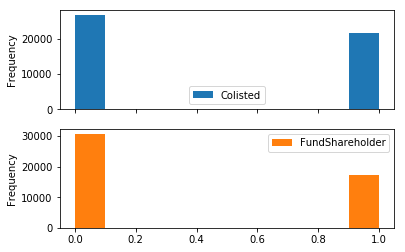

In [358]:
final_ready_data[['Colisted','FundShareholder']].plot.hist(subplots=True)

In [360]:
writer = pd.ExcelWriter('betty_data/group_test_result.xlsx', engine='xlsxwriter')

### 5.1 Model 1 

In [361]:
group_keys=[]
model_dfs=[]
dis_similarity={}
meta_pvs=[]
for g in ['Colisted','FundShareholder']:
    for gv in [0,1]:
        model_results=[]
        for y in ['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']:
            data=final_ready_data[[y,'RelativeAnaExperience','RelativeCoNumber','RelativeNumber'
                       ,'IsStarAnalyst', 'AnalystExperience','FollowCoNumber','ForecastNumber','roe','LOSS','Colisted','FundShareholder']].dropna()
            data=data.apply(lambda x: x.astype(np.float64))
            data=winsoriz(data,[y,'RelativeAnaExperience', 'RelativeCoNumber',
                   'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
                   'ForecastNumber', 'roe'])
            expression=build_R_style_expression(y,['RelativeAnaExperience', 'RelativeCoNumber',
               'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
               'ForecastNumber', 'roe'],['LOSS','IsStarAnalyst'])
            model=smf.api.ols(expression,data=data[data[g]==gv]).fit()
            meta_pvs.append(model.pvalues.values)
            index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
            model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
            model_results.append(model_result)
        model_df=pd.DataFrame()
        for df in model_results:
            model_df=pd.concat((model_df,df),axis=1)
        model_dfs.append(model_df)
        group_keys.append('%s=%d'%(g,gv))
model_results=[]
for y in ['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']:
    data=final_ready_data[[y,'RelativeAnaExperience','RelativeCoNumber','RelativeNumber'
               ,'IsStarAnalyst', 'AnalystExperience','FollowCoNumber','ForecastNumber','roe','LOSS','Colisted','FundShareholder']].dropna()
    data=data.apply(lambda x: x.astype(np.float64))
    data=winsoriz(data,[y,'RelativeAnaExperience', 'RelativeCoNumber',
           'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
           'ForecastNumber', 'roe'])
    expression=build_R_style_expression(y,['RelativeAnaExperience', 'RelativeCoNumber',
       'RelativeNumber', 'AnalystExperience', 'FollowCoNumber',
       'ForecastNumber', 'roe'],['LOSS','IsStarAnalyst'])
    model=smf.api.ols(expression,data=data).fit()
    meta_pvs.append(model.pvalues.values)
    index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
    model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
    model_results.append(model_result)
model_df=pd.DataFrame()
for df in model_results:
    model_df=pd.concat((model_df,df),axis=1)
model_dfs.append(model_df)
group_keys.append('Original')
meta_pvs=np.array(meta_pvs)
group_test_df=pd.concat(model_dfs,axis=1,keys=group_keys,names=['Group','Variable'])
group_test_df.to_excel(writer,sheet_name='model1_gtest')
group_test_df

Group                                Colisted=0                   \
Variable                       ForecastOptimism RelativeOptimism   
var                     values                                     
Intercept               coef         0.02436***       0.07377***   
                        t              (35.513)          (2.781)   
C(LOSS)[T.1.0]          coef            0.00073         -0.00430   
                        t               (1.578)         (-0.242)   
C(IsStarAnalyst)[T.1.0] coef        -0.00470***          0.00349   
                        t              (-7.701)          (0.149)   
RelativeAnaExperience   coef           -0.00002       -0.00683**   
                        t              (-0.339)         (-2.559)   
RelativeCoNumber        coef        -0.00019***          0.00094   
                        t              (-9.199)          (1.205)   
RelativeNumber          coef           0.00001*          0.00024   
                        t               (1.917)          (1.024)   
AnalystExperience       coef         0.00019***         0.00370*   
                        t               (3.339)          (1.728)   
FollowCoNumber          coef         0.00021***      -0.00423***   
                        t               (6.956)         (-3.741)   
ForecastNumber          coef        -0.00003***       0.00151***   
                        t              (-2.764)          (3.306)   
roe                     coef        -0.04756***        -0.11087*   
                        t             (-30.919)         (-1.883)   

Group                                                                   \
Variable                       RelativeRecommendation RelativeAccuracy   
var                     values                                           
Intercept               coef                  0.00377      -0.14563***   
                        t                     (0.309)         (-5.903)   
C(LOSS)[T.1.0]          coef                 0.01564*          0.00780   
                        t                     (1.920)          (0.471)   
C(IsStarAnalyst)[T.1.0] coef              -0.07244***         0.03936*   
                        t                    (-6.667)          (1.812)   
RelativeAnaExperience   coef                  0.00111         0.00426*   
                        t                     (0.877)          (1.714)   
RelativeCoNumber        coef              -0.00184***      -0.00212***   
                        t                    (-4.884)         (-2.917)   
RelativeNumber          coef               0.00075***          0.00031   
                        t                     (6.781)          (1.463)   
AnalystExperience       coef               -0.00200**         -0.00201   
                        t                    (-1.980)         (-1.010)   
FollowCoNumber          coef              -0.00172***          0.00109   
                        t                    (-3.211)          (1.036)   
ForecastNumber          coef               0.00088***         -0.00032   
                        t                     (4.024)         (-0.753)   
roe                     coef                  0.02427        0.11104**   
                        t                     (0.885)          (2.027)   

Group                                Colisted=1                   \
Variable                       ForecastOptimism RelativeOptimism   
var                     values                                     
Intercept               coef         0.02043***       0.12823***   
                        t              (28.066)          (4.795)   
C(LOSS)[T.1.0]          coef         0.00676***        0.04226**   
                        t              (13.825)          (2.361)   
C(IsStarAnalyst)[T.1.0] coef         0.00437***        0.05147**   
                        t               (7.389)          (2.373)   
RelativeAnaExperience   coef         -0.00017**         -0.00410   
                        t              (-2.263)     

,Co0-Ori,Co1-Ori,Colisted,Fs0-Ori,Fs1-Ori,FundShareholder
ForecastOptimism,0.164515,0.188751,0.139167,0.113043,0.094340,0.013911
RelativeAccuracy,0.062568,0.096951,0.143133,0.037244,0.090644,0.166728
RelativeOptimism,0.132146,0.038771,0.204006,0.105310,0.029367,0.116619
RelativeRecommendation,0.064907,0.003166,0.064874,0.167720,0.012255,0.160272


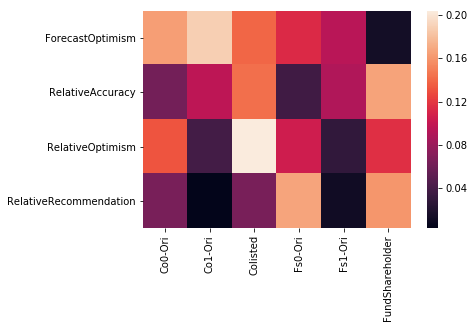

In [362]:
meta_pvs=np.array(meta_pvs)
mse_result={}
for y,yname in enumerate(['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']):
    group_mse={}
    for g0,g1,gname in [(0,4,'Colisted'),(8,12,'FundShareholder'),(0,16,'Co0-Ori'),(4,16,'Co1-Ori'),(8,16,'Fs0-Ori'),(12,16,'Fs1-Ori')]:
        group_mse[gname]=np.mean(np.square(meta_pvs[g0+y]-meta_pvs[g1+y]))
    mse_result[yname]=group_mse
gtest_mse=pd.DataFrame(mse_result).T
sns.heatmap(gtest_mse)
gtest_mse

---
### 5.2 Model 2

In [363]:
group_keys=[]
model_dfs=[]
dis_similarity={}
meta_pvs=[]
for g in ['Colisted','FundShareholder']:
    for gv in [0,1]:
        model_results=[]
        for y in ['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']:
            data=final_ready_data[[y,'CompanyOpacity','ReportAttention','AnaAttention'
                       ,'TotalFinancialProportion', 'SecLoct','LOSS','Big4','growth','CompanySize','roe','EPS','Colisted','FundShareholder']].dropna()
            data=data.apply(lambda x: x.astype(np.float64))
            data=winsoriz(data,[y,'ForecastOptimism','ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe',
       'EPS','CompanySize'])
            expression=build_R_style_expression(y,['ReportAttention', 'AnaAttention',
       'TotalFinancialProportion', 'growth', 'roe','EPS','CompanyOpacity','np.log(CompanySize)'],['LOSS','Big4','SecLoct'])
            model=smf.api.ols(expression,data=data[data[g]==gv]).fit()
            meta_pvs.append(model.pvalues.values)
            index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
            model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
            model_results.append(model_result)
        model_df=pd.DataFrame()
        for df in model_results:
            model_df=pd.concat((model_df,df),axis=1)
        model_dfs.append(model_df)
        group_keys.append('%s=%d'%(g,gv))
model_results=[]
for y in ['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']:
    data=final_ready_data[[y,'CompanyOpacity','ReportAttention','AnaAttention'
               ,'TotalFinancialProportion', 'SecLoct','LOSS','Big4','growth','CompanySize','roe','EPS','Colisted','FundShareholder']].dropna()
    data=data.apply(lambda x: x.astype(np.float64))
    data=winsoriz(data,[y,'ForecastOptimism','ReportAttention', 'AnaAttention',
'TotalFinancialProportion', 'growth', 'roe',
'EPS','CompanySize'])
    expression=build_R_style_expression(y,['ReportAttention', 'AnaAttention',
'TotalFinancialProportion', 'growth', 'roe','EPS','CompanyOpacity','np.log(CompanySize)'],['LOSS','Big4','SecLoct'])
    model=smf.api.ols(expression,data=data).fit()
    meta_pvs.append(model.pvalues.values)
    index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
    model_result=pd.DataFrame(list(chain.from_iterable(zip(model.pvalues.apply(annotate_star),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
    model_results.append(model_result)
model_df=pd.DataFrame()
for df in model_results:
    model_df=pd.concat((model_df,df),axis=1)
model_dfs.append(model_df)
group_keys.append('Original')
meta_pvs=np.array(meta_pvs)
group_test_df=pd.concat(model_dfs,axis=1,keys=group_keys,names=['Group','Variable'])
group_test_df.to_excel(writer,sheet_name='model2_gtest')
group_test_df

Group                                 Colisted=0                   \
Variable                        ForecastOptimism RelativeOptimism   
var                      values                                     
Intercept                coef        -0.12285***          0.34225   
                         t             (-21.072)          (1.547)   
C(LOSS)[T.1.0]           coef           -0.00056      -0.06680***   
                         t              (-0.843)         (-2.583)   
C(Big4)[T.1.0]           coef        -0.00760***         -0.00488   
                         t             (-10.708)         (-0.183)   
C(SecLoct)[T.1.0]        coef        -0.00525***         0.05216*   
                         t              (-6.434)          (1.660)   
ReportAttention          coef        -0.00009***        0.00136**   
                         t              (-5.596)          (2.293)   
AnaAttention             coef          -0.00008*      -0.00599***   
                         t              (-1.649)         (-3.466)   
TotalFinancialProportion coef        -0.00038***         -0.00091   
                         t              (-7.743)         (-0.473)   
growth                   coef        -0.00427***          0.01631   
                         t              (-6.462)          (0.727)   
roe                      coef        -0.03475***          0.02644   
                         t             (-13.943)          (0.273)   
EPS                      coef         0.00577***          0.04189   
                         t               (8.263)          (1.610)   
CompanyOpacity           coef         0.00485***         -0.00606   
                         t              (11.744)         (-0.382)   
np.log(CompanySize)      coef         0.00656***         -0.00908   
                         t              (26.940)         (-0.987)   

Group                                                                    \
Variable                        RelativeRecommendation RelativeAccuracy   
var                      values                                           
Intercept                coef               0.76886***         -0.18192   
                         t                     (6.893)         (-0.896)   
C(LOSS)[T.1.0]           coef                 -0.01773       0.06132***   
                         t                    (-1.374)          (2.582)   
C(Big4)[T.1.0]           coef               0.04589***         -0.01648   
                         t                     (3.452)         (-0.674)   
C(SecLoct)[T.1.0]        coef                 -0.01578         -0.04609   
                         t                    (-1.002)         (-1.597)   
ReportAttention          coef              -0.00170***         -0.00065   
                         t                    (-5.645)         (-1.192)   
AnaAttention             coef               0.00372***       0.00758***   
                         t                     (4.251)          (4.771)   
TotalFinancialProportion coef                  0.00103          0.00132   
                         t                     (1.068)          (0.746)   
growth                   coef                 -0.00668         -0.01397   
                         t                    (-0.607)         (-0.679)   
roe                      coef                 -0.01799         -0.09602   
                         t                    (-0.377)         (-1.079)   
EPS                      coef                  0.00306         -0.01384   
                         t                     (0.235)         (-0.579)   
CompanyOpacity           coef                  0.00708         -0.00192   
                         t                     (0.901)         (-0.132)   
np.log(CompanySize)      coef              -0.03373***         -0.00279   
                         t                    (-7.269)         (-0.330)   

Group                                 Colisted=1                   \
Variable                        ForecastO

,Co0-Ori,Co1-Ori,Colisted,Fs0-Ori,Fs1-Ori,FundShareholder
ForecastOptimism,0.013738,0.001508,0.015561,0.000056,0.004819,0.005862
RelativeAccuracy,0.135287,0.141892,0.170331,0.170515,0.130605,0.290771
RelativeOptimism,0.104653,0.132844,0.189016,0.058012,0.200421,0.170354
RelativeRecommendation,0.059698,0.036892,0.124686,0.077944,0.196853,0.245092


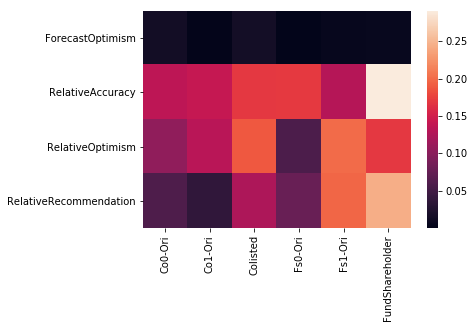

In [364]:
meta_pvs=np.array(meta_pvs)
mse_result={}
for y,yname in enumerate(['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']):
    group_mse={}
    for g0,g1,gname in [(0,4,'Colisted'),(8,12,'FundShareholder'),(0,16,'Co0-Ori'),(4,16,'Co1-Ori'),(8,16,'Fs0-Ori'),(12,16,'Fs1-Ori')]:
        group_mse[gname]=np.mean(np.square(meta_pvs[g0+y]-meta_pvs[g1+y]))
    mse_result[yname]=group_mse
gtest_mse=pd.DataFrame(mse_result).T
sns.heatmap(gtest_mse)
gtest_mse

---
### 5.3. Model 3

In [365]:
group_keys=[]
model_dfs=[]
dis_similarity={}
meta_pvs=[]
for g in ['Colisted','FundShareholder']:
    for gv in [0,1]:
        model_results=[]
        for y in ['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']:
            data=final_ready_data[[y,'SecSize','StarAnalyst','ActiveAnalyst'
                       ,'SecLoct', 'ReportNumber','underwriter','CompanySize','roe','EPS','Colisted','FundShareholder']].dropna()
            data=data.apply(lambda x: x.astype(np.float64))
            data=winsoriz(data,[y,'StarAnalyst', 'ActiveAnalyst',
       'ReportNumber', 'CompanySize','roe','EPS'])
            expression=build_R_style_expression(y,['StarAnalyst', 'ActiveAnalyst',
       'ReportNumber','np.log(CompanySize)','roe','EPS'],['SecSize','SecLoct','underwriter'])
            model=smf.api.ols(expression,data=data[data[g]==gv]).fit()
            meta_pvs.append(model.pvalues.values)
            index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
            model_result=pd.DataFrame(list(chain.from_iterable(zip(build_model_result(model),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
            model_results.append(model_result)
        model_df=pd.DataFrame()
        for df in model_results:
            model_df=pd.concat((model_df,df),axis=1)
        model_dfs.append(model_df)
        group_keys.append('%s=%d'%(g,gv))
model_results=[]
for y in ['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']:
    data=final_ready_data[[y,'SecSize','StarAnalyst','ActiveAnalyst'
               ,'SecLoct', 'ReportNumber','underwriter','CompanySize','roe','EPS','Colisted','FundShareholder']].dropna()
    data=data.apply(lambda x: x.astype(np.float64))
    data=winsoriz(data,[y,'StarAnalyst', 'ActiveAnalyst',
'ReportNumber', 'CompanySize','roe','EPS'])
    expression=build_R_style_expression(y,['StarAnalyst', 'ActiveAnalyst',
'ReportNumber','np.log(CompanySize)','roe','EPS'],['SecSize','SecLoct','underwriter'])
    model=smf.api.ols(expression,data=data).fit()
    meta_pvs.append(model.pvalues.values)
    index=pd.MultiIndex(levels=[model.pvalues.index,['coef','t']],labels=[sorted(list(range(model.pvalues.shape[0]))*2),[0,1]*model.pvalues.shape[0]],names=['var','values'])
    model_result=pd.DataFrame(list(chain.from_iterable(zip(model.pvalues.apply(annotate_star),model.tvalues.apply('({:.3f})'.format)))),index=index,columns=[data.columns[0]])
    model_results.append(model_result)
model_df=pd.DataFrame()
for df in model_results:
    model_df=pd.concat((model_df,df),axis=1)
model_dfs.append(model_df)
group_keys.append('Original')
meta_pvs=np.array(meta_pvs)
group_test_df=pd.concat(model_dfs,axis=1,keys=group_keys,names=['Group','Variable'])
group_test_df.to_excel(writer,sheet_name='model3_gtest')
group_test_df

Group                              Colisted=0                   \
Variable                     ForecastOptimism RelativeOptimism   
var                   values                                     
Intercept             coef        -0.09357***          0.37253   
                      t             (-17.663)          (1.566)   
C(SecSize)[T.1.0]     coef            0.00039         0.06475*   
                      t               (0.527)          (1.918)   
C(SecLoct)[T.1.0]     coef        -0.00669***         -0.04921   
                      t              (-6.476)         (-1.079)   
C(underwriter)[T.1.0] coef        -0.00201***          0.03623   
                      t              (-2.929)          (1.176)   
StarAnalyst           coef         0.00028***          0.00034   
                      t               (7.653)          (0.212)   
ActiveAnalyst         coef         0.00011***          0.00152   
                      t               (4.323)          (1.394)   
ReportNumber          coef        -0.00001***         -0.00005   
                      t              (-8.401)         (-0.950)   
np.log(CompanySize)   coef         0.00523***         -0.01356   
                      t              (22.839)         (-1.335)   
roe                   coef        -0.03696***      -0.42864***   
                      t             (-13.786)         (-3.560)   
EPS                   coef         -0.00171**          0.00711   
                      t              (-2.570)          (0.247)   

Group                                                                 \
Variable                     RelativeRecommendation RelativeAccuracy   
var                   values                                           
Intercept             coef               0.47674***      -0.82818***   
                      t                     (4.776)         (-3.700)   
C(SecSize)[T.1.0]     coef               0.07544***          0.03852   
                      t                     (5.447)          (1.212)   
C(SecLoct)[T.1.0]     coef                 -0.02701         -0.02298   
                      t                    (-1.408)         (-0.535)   
C(underwriter)[T.1.0] coef               0.05122***        0.06000**   
                      t                     (3.990)          (2.069)   
StarAnalyst           coef              -0.00521***          0.00018   
                      t                    (-7.674)          (0.119)   
ActiveAnalyst         coef              -0.00136***          0.00066   
                      t                    (-2.946)          (0.644)   
ReportNumber          coef               0.00010***         -0.00007   
                      t                     (4.886)         (-1.425)   
np.log(CompanySize)   coef              -0.02329***       0.02628***   
                      t                    (-5.442)          (2.748)   
roe                   coef                 -0.02348          0.09100   
                      t                    (-0.478)          (0.803)   
EPS                   coef                  0.00414          0.03068   
                      t                     (0.351)          (1.132)   

Group                              Colisted=1                   \
Variable                     ForecastOptimism RelativeOptimism   
var                   values                                     
Intercept             coef        -0.08612***        0.43965**   
                      t             (-19.340)          (2.305)   
C(SecSize)[T.1.0]     coef         0.00482***       0.08585***   
                      t               (6.675)          (2.796)   
C(SecLoct)[T.1.0]     coef          -0.00177*         -0.03365   
                      t              (-1.808)         (-0.784)   
C(underwriter)[T.1.0] coef         -0.00140**         -0.00431   
                      t              (-2.294)         (-0.164)   
StarAnalyst           coef         0.00016***         -0.00048   
                      t         

,Co0-Ori,Co1-Ori,Colisted,Fs0-Ori,Fs1-Ori,FundShareholder
ForecastOptimism,0.117409,0.084052,0.045566,0.083140,0.059317,0.004731
RelativeAccuracy,0.102281,0.007515,0.085691,0.132646,0.128740,0.183447
RelativeOptimism,0.029766,0.030501,0.076422,0.023681,0.056160,0.067155
RelativeRecommendation,0.090633,0.033806,0.055138,0.031580,0.063674,0.040529


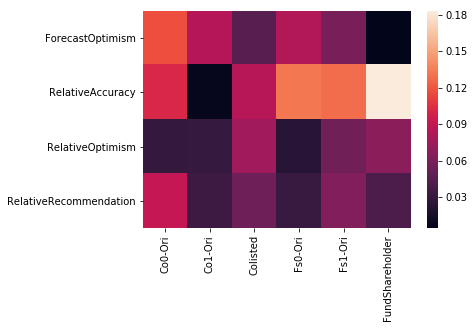

In [366]:
meta_pvs=np.array(meta_pvs)
mse_result={}
for y,yname in enumerate(['ForecastOptimism','RelativeOptimism','RelativeRecommendation','RelativeAccuracy']):
    group_mse={}
    for g0,g1,gname in [(0,4,'Colisted'),(8,12,'FundShareholder'),(0,16,'Co0-Ori'),(4,16,'Co1-Ori'),(8,16,'Fs0-Ori'),(12,16,'Fs1-Ori')]:
        group_mse[gname]=np.mean(np.square(meta_pvs[g0+y]-meta_pvs[g1+y]))
    mse_result[yname]=group_mse
gtest_mse=pd.DataFrame(mse_result).T
sns.heatmap(gtest_mse)
gtest_mse

In [367]:
writer.save()